# **Imports 📢**

In [30]:
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy
from tqdm import tqdm
#from keras.datasets import cifar10


# **Init**

In [31]:
num_cls = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Utils 🧰**

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [33]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [34]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

# **Dataset 🗂️**

## Transform

In [35]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [36]:
transform_train = T.Compose([T.RandomCrop(32, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                         std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                        std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [37]:
train_set = CIFAR10(root=r'./Users/Mahsaa/OneDrive/Desktop', train=True, 
                    download=True, 
                    transform=transform_train)

test_set = CIFAR10(root=r'./Users/Mahsaa/OneDrive/Desktop', train=False, 
                   download=True,
                   transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
train_set.data.shape

(50000, 32, 32, 3)

## DataLoader

In [39]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [40]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([7, 8, 4, 7, 2, 2, 1, 7, 9, 3, 3, 6, 4, 7, 2, 9, 2, 4, 5, 6, 9, 6, 8, 5,
        8, 4, 0, 6, 4, 5, 6, 4, 7, 5, 7, 7, 3, 8, 0, 2, 3, 6, 6, 5, 8, 1, 5, 6,
        1, 1, 5, 1, 2, 2, 2, 3, 8, 7, 6, 9, 2, 2, 9, 2])


## Visualize

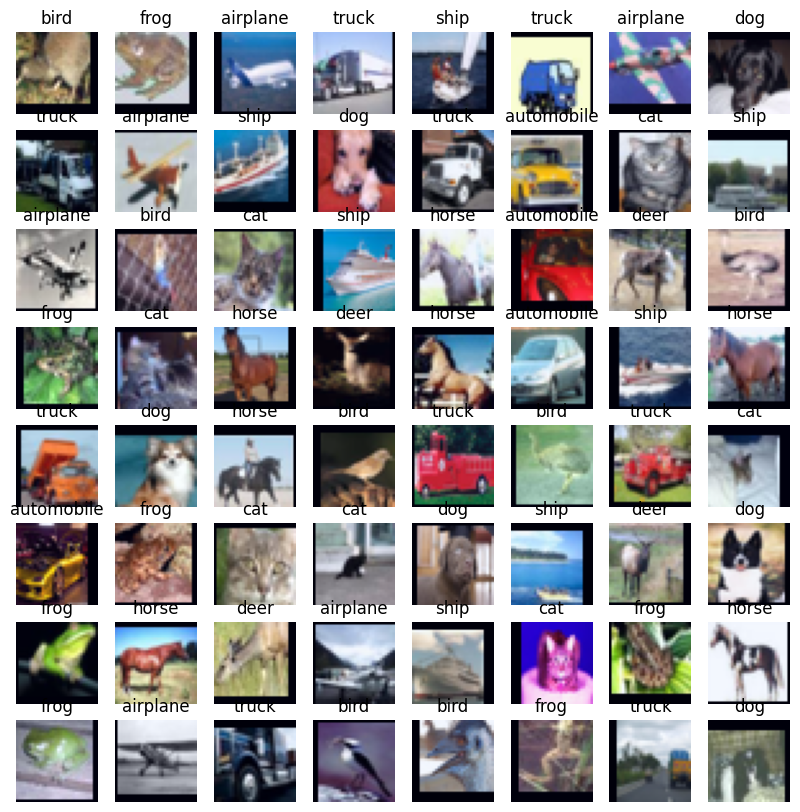

In [41]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [42]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [43]:
def Teacher():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [44]:
def Student():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [45]:
teacher = Teacher().to(device)
num_params(teacher)

4.694346

In [46]:
student = Student().to(device)
num_params(student)

1.558026

# **Functions** 🧮

In [47]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [48]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [49]:
def train_one_epoch_kd(student, teacher, train_loader, loss_fn, optimizer, epoch=None):
  student.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = student(inputs)
      with torch.no_grad():
        teacher_outputs = teacher(inputs)
      
      loss = loss_fn(outputs, targets, teacher_outputs, T=10, alpha=0.6)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return student, loss_train.avg, acc_train.compute().item()

In [ ]:
**Train Teacher & Student Models 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [50]:
model = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3436, grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [52]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [53]:
model = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

In [54]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

## Step 3: select best lr

Train all data for one epoch